HUMO-LUMO energy gap prediction using Graph Convolution from Deepchem graph convolution module   9/20/2020

In [16]:
import numpy as np
from deepchem.models import GraphConvModel
import tensorflow as tf
import deepchem as dc
#from deepchem.molnet import load_delaney
import sklearn
from sklearn.metrics import r2_score
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

In [2]:
dataset = pd.read_excel('C:/Users/Gashaw/Documents/DataAndSoftware_S1-S4/Orbital_Energies_input_data.xlsx')
dataset.head()

,SMILES,Energygap
0,Nc1ccc(cc1)C(F)(F)F,177.756984
1,CNC1CCCCC1,215.558754
2,C/C=C/C(C)C,220.858695
3,OC(=O)c1ccccc1c1ccccc1,168.397060
4,OC(=O)/C=C\c1c[nH]c2ccccc12,144.475790


In [3]:
  X, y  = dataset['SMILES'], dataset['Energygap']
    

In [4]:
y

0       177.756984
1       215.558754
2       220.858695
3       168.397060
4       144.475790
           ...    
2899    217.786411
2900    156.612441
2901    220.300840
2902    270.098071
2903    177.377969
Name: Energygap, Length: 2904, dtype: float64

In [5]:
X

0                       Nc1ccc(cc1)C(F)(F)F
1                                CNC1CCCCC1
2                               C/C=C/C(C)C
3                    OC(=O)c1ccccc1c1ccccc1
4               OC(=O)/C=C\c1c[nH]c2ccccc12
                       ...                 
2899                              O=c1occo1
2900                  OC(=O)Cc1cccc2ccccc12
2901                  CC(=O)CC(=O)OC(C)(C)C
2902    FC(F)(F)S(=O)(=O)OS(=O)(=O)C(F)(F)F
2903                        COc1ccc(cc1)C#N
Name: SMILES, Length: 2904, dtype: object

In [6]:
dataset_file = "C:/Users/Gashaw/Documents/DataAndSoftware_S1-S4/Orbital_Energies_input_data.csv"

In [7]:
tasks = ['Energygap']
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
tasks=tasks, smiles_field="SMILES", featurizer=featurizer)
dataset = loader.featurize(dataset_file, shard_size=8192)

# Initialize transformers
transformers = [
dc.trans.NormalizationTransformer(
  transform_y=True, dataset=dataset)
]

print("About to transform data")
for transformer in transformers:
    dataset = transformer.transform(dataset)

splitter = dc.splits.IndexSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from C:/Users/Gashaw/Documents/DataAndSoftware_S1-S4/Orbital_Energies_input_data.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
TIMING: featurizing shard 0 took 3.276 s
TIMING: dataset construction took 3.979 s
Loading dataset from disk.
About to transform data
TIMING: dataset construction took 1.048 s
Loading dataset from disk.
TIMING: dataset construction took 0.815 s
Loading dataset from disk.
TIMING: dataset construction took 0.444 s
Loading dataset from disk.
TIMING: dataset construction took 0.426 s
Loading dataset from disk.


In [8]:
# Fit models
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)
# Number of features on conv-mols
n_feat = 75
# Batch size of models
batch_size = 128
model = GraphConvModel(
    len(tasks), batch_size=batch_size, mode='regression')

In [9]:
# Fit trained model
model.fit(train_dataset, nb_epoch=15)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
C:\Users\Gashaw\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Gashaw\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Gashaw\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18.968220117008478

In [10]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

Evaluating model
computed_metrics: [0.9488291670419079]
computed_metrics: [0.8729108905015938]
Train scores
{'mean-pearson_r2_score': 0.9488291670419079}
Validation scores
{'mean-pearson_r2_score': 0.8729108905015938}


In [11]:
predicted_test = model.predict(test_dataset)
predicted_test.size

291

In [12]:
true_test = test_dataset.y
true_test.size

291

In [13]:
len(test_dataset)

291

In [14]:
# R^2 (coefficient of determination) regression score function: 
R2 =r2_score(true_test, predicted_test)
print('R2:', R2)

R2: 0.8678176351544123


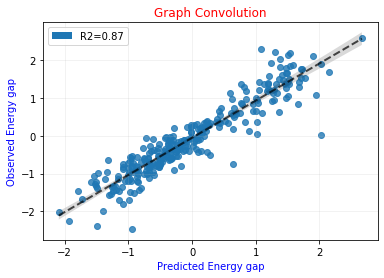

In [15]:
sn.regplot(x=predicted_test, y=true_test, line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Graph Convolution", color='red')
plt.grid(alpha=0.2)
R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
plt.legend(handles=[R2])